# CIB Bandpower Analysis
## Viero et al. 2019 SPT×SPIRE Cross-Spectra

This notebook demonstrates how to use the `cib_analysis` module to analyze
CIB cross-frequency power spectra.

In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))  # Adjust according to your directory

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the CIB analysis module
from models.cib_analysis import (
    CIBData, CIBModel, CIBFitter, 
    CIBDiagnostics, quick_fit
)

from plotting.cib_plotting import (
    CIBPlotter
)


## 1. Load Data

First, load the bandpower data from the Viero et al. 2019 data files.

In [4]:
# Set the path to your data directory
data_dir = os.path.join('..', 'data')

# Load data
data = CIBData(data_dir)

# List available frequency pairs
data.list_pairs()

Pair         N_bp   Scale      Units       
----------------------------------------
95x95        12     1.0000     μK²_CMB     
95x150       14     1.0000     μK²_CMB     
95x220       14     1.0000     μK²_CMB     
150x150      14     2.0000     MJy²/sr     
150x220      14     2.0000     MJy²/sr     
220x220      14     2.0000     MJy²/sr     
95x600       15     1.5000     μK²_CMB     
95x857       15     1.5000     μK²_CMB     
95x1200      20     1.5000     MJy²/sr     
150x600      20     1.0000     MJy²/sr     
150x857      20     1.0000     MJy²/sr     
150x1200     15     0.2000     μK²_CMB     
220x600      21     0.3500     MJy²/sr     
220x857      21     0.2500     MJy²/sr     
220x1200     21     0.2000     MJy²/sr     
600x600      22     0.0500     MJy²/sr     
600x857      22     0.0280     MJy²/sr     
600x1200     22     0.0320     MJy²/sr     
857x857      22     0.0150     MJy²/sr     
857x1200     22     0.0100     MJy²/sr     
1200x1200    22     0.0090     MJy²

## 2. Explore the Data

Look at the bandpowers for the SPIRE frequency pairs.

In [5]:
# Get data for a specific pair
ell, Cl, err = data.get_pair('600x600', physical_units=True)

print(f"600×600 GHz:")
print(f"  ℓ range: {ell.min():.0f} - {ell.max():.0f}")
print(f"  Cl range: {Cl.min():.1f} - {Cl.max():.1f} MJy²/sr")

600×600 GHz:
  ℓ range: 700 - 10399
  Cl range: 2690.5 - 18900.7 MJy²/sr


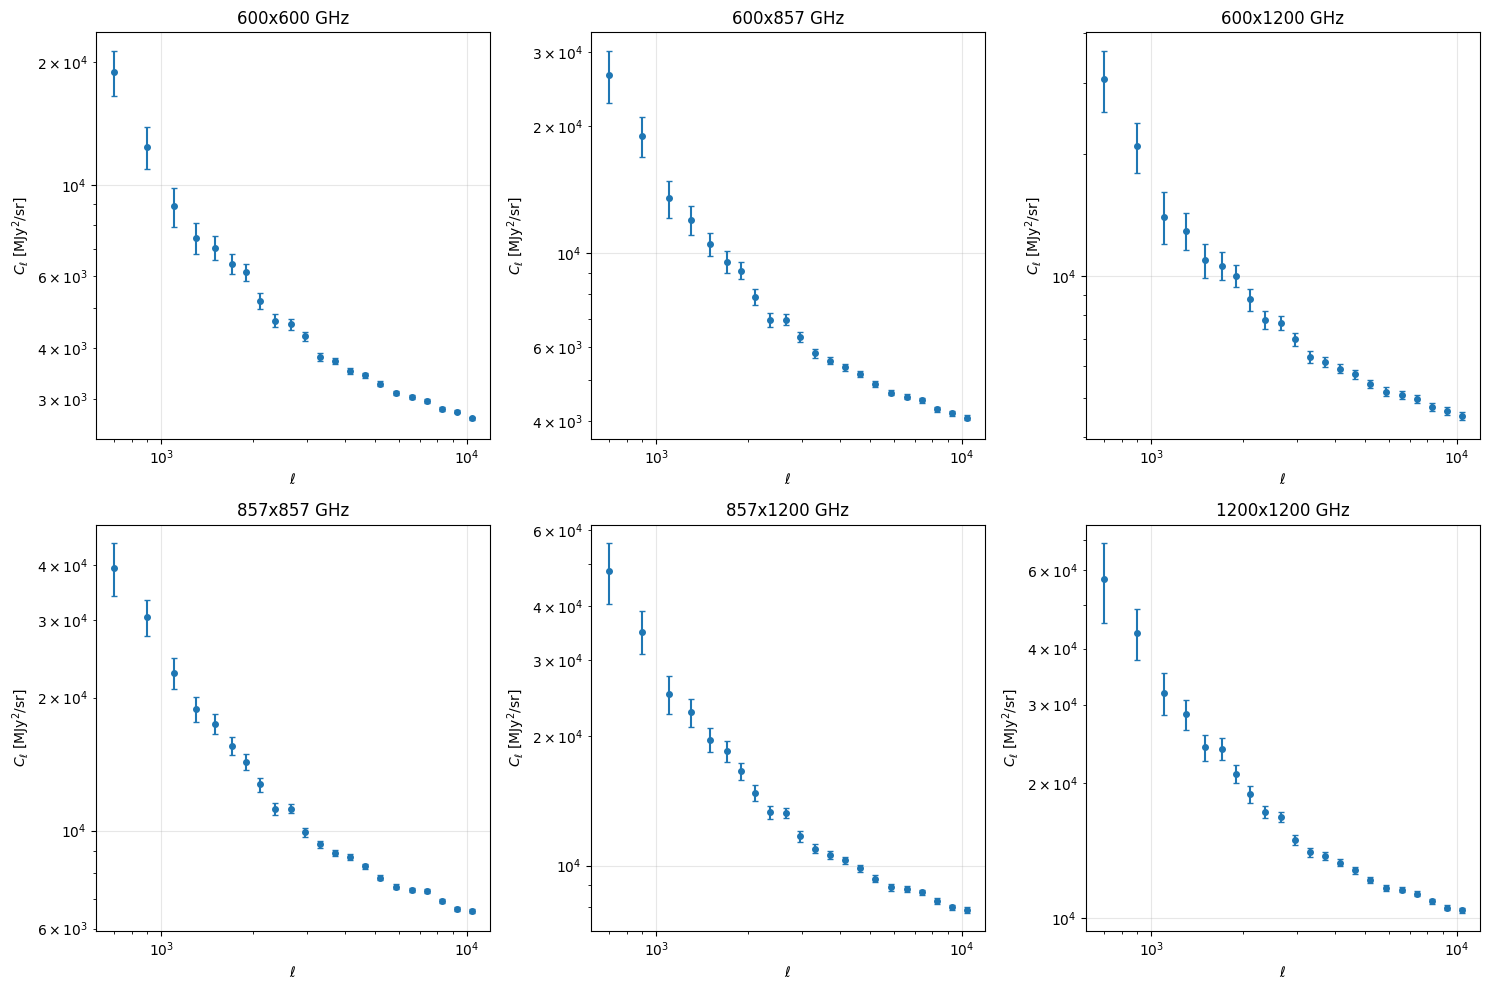

In [6]:
# Plot all SPIRE bandpowers
fig, axes = CIBPlotter.plot_bandpowers(data, pairs=CIBData.SPIRE_PAIRS)
plt.show()

## 3. Diagnostics: Correlation Coefficients

Compute the Pearson correlation coefficient $r(\ell)$ for cross-spectra:

$$r(\ell) = \frac{C_{ij}(\ell)}{\sqrt{C_{ii}(\ell) \times C_{jj}(\ell)}}$$

If $r < 1$, it indicates decorrelation between frequencies.

In [7]:
# Create diagnostics object
diag = CIBDiagnostics(data)

# Print correlation coefficient summary
diag.correlation_summary()

CORRELATION COEFFICIENTS r(ℓ) = C_ij / sqrt(C_ii × C_jj)

600x857:
  Mean r = 0.9698 ± 0.0026
  Range: [0.9498, 1.0138]

600x1200:
  Mean r = 0.8678 ± 0.0045
  Range: [0.8349, 0.9360]

857x1200:
  Mean r = 0.9579 ± 0.0032
  Range: [0.9269, 1.0161]

------------------------------------------------------------
Binned averages:
Pair         ℓ<2000     2000<ℓ<5000    ℓ>5000    
600x857      0.9699     0.9706         0.9688    
600x1200     0.8783     0.8686         0.8564    
857x1200     0.9637     0.9565         0.9538    


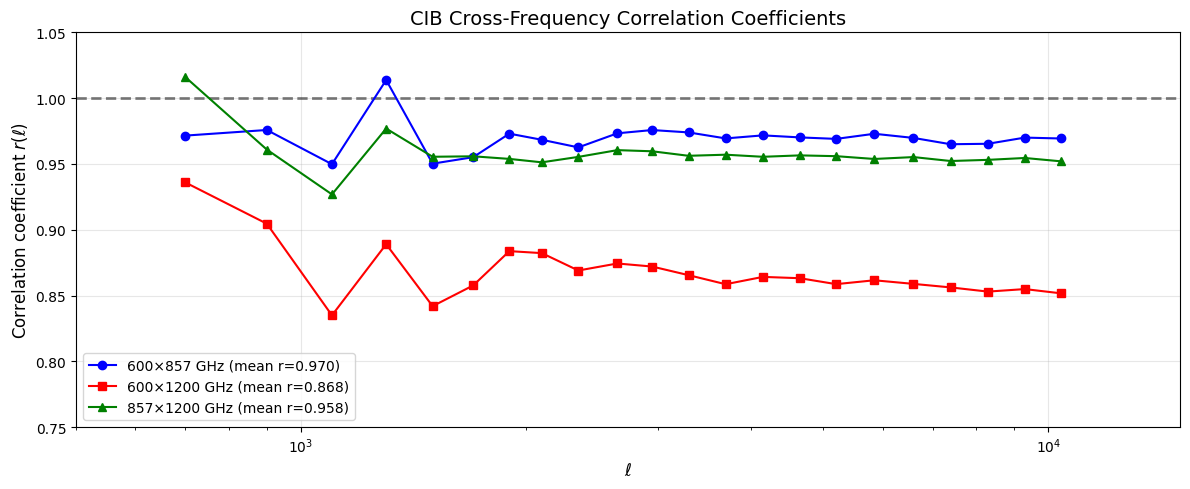

In [8]:
# Plot correlation coefficients
fig, ax = CIBPlotter.plot_correlation_coefficients(data)
plt.show()

In [9]:
# Get the actual r values
r_dict = diag.correlation_coefficients()

for pair, r in r_dict.items():
    print(f"{pair}: mean r = {np.mean(r):.4f}")

600x857: mean r = 0.9698
600x1200: mean r = 0.8678
857x1200: mean r = 0.9579


## 4. Model Fitting

### 4.1 Simple Model (r=1 assumed)

The simple model assumes perfect correlation between frequencies:

$$C_{\ell}(\nu_1, \nu_2) = s(\nu_1) \times s(\nu_2) \times P(\ell)$$

where $P(\ell)$ is the power spectrum shape.

In [10]:
# Create simple model with 3 terms (shot noise + 1-halo + 2-halo)
model_simple = CIBModel(model_type='simple', n_terms=3)

print("Simple model parameters:")
for name in model_simple.param_names:
    print(f"  - {name}")

Simple model parameters:
  - C_shot
  - C_1h
  - alpha_1h
  - C_2h
  - alpha_2h
  - s857
  - s1200


In [11]:
# Fit the simple model
fitter_simple = CIBFitter(data, model_simple, pairs=CIBData.SPIRE_PAIRS)
result_simple = fitter_simple.fit()

print(result_simple)

FitResult(χ²/dof = 581.2/125 = 4.65)
  C_shot: 0.0000
  C_1h: 2993.1025
  alpha_1h: -0.1298
  C_2h: 998.9958
  alpha_2h: -1.7561
  s857: 1.5693
  s1200: 1.9296


### 4.2 Correlation Model

The correlation model allows for decorrelation between frequencies:

$$C_{\ell}(\nu_i, \nu_j) = r_{ij} \times \sqrt{A_i \times A_j} \times P(\ell)$$

where $r_{ij}$ is the correlation coefficient.

In [12]:
# Create correlation model
model_corr = CIBModel(model_type='correlation', n_terms=3)

print("Correlation model parameters:")
for name in model_corr.param_names:
    print(f"  - {name}")

Correlation model parameters:
  - C_shot
  - C_1h
  - alpha_1h
  - C_2h
  - alpha_2h
  - A857
  - A1200
  - r_600_857
  - r_600_1200
  - r_857_1200


In [13]:
# Fit the correlation model
fitter_corr = CIBFitter(data, model_corr, pairs=CIBData.SPIRE_PAIRS)
result_corr = fitter_corr.fit()

print(result_corr)

FitResult(χ²/dof = 90.4/122 = 0.74)
  C_shot: 0.0000
  C_1h: 3087.8197
  alpha_1h: -0.1361
  C_2h: 1019.8758
  alpha_2h: -1.7652
  A857: 2.4248
  A1200: 3.7754
  r_600_857: 0.9698
  r_600_1200: 0.8601
  r_857_1200: 0.9549


In [14]:
# Compare models
print(f"\nModel comparison:")
print(f"  Simple model:      χ²/dof = {result_simple.chi2_reduced:.2f}")
print(f"  Correlation model: χ²/dof = {result_corr.chi2_reduced:.2f}")
print(f"\n  Δχ² = {result_simple.chi2 - result_corr.chi2:.1f} for {result_corr.n_params - result_simple.n_params} extra parameters")


Model comparison:
  Simple model:      χ²/dof = 4.65
  Correlation model: χ²/dof = 0.74


AttributeError: 'FitResult' object has no attribute 'n_params'

## 5. Visualize Fit Results

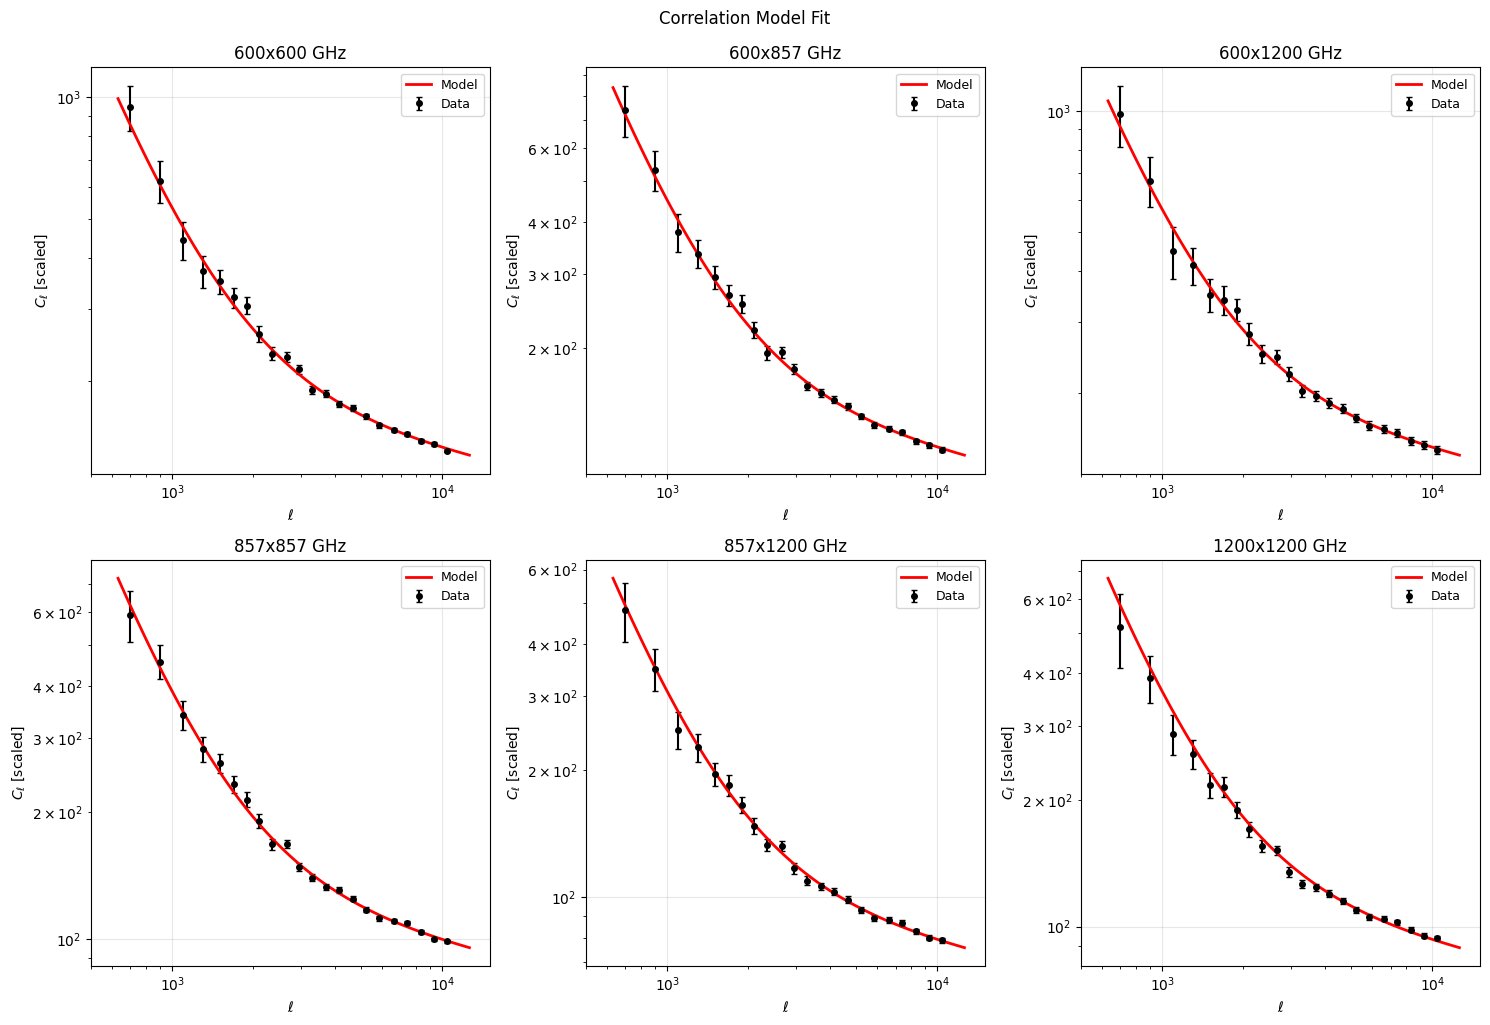

In [15]:
# Plot fit
fig, axes = CIBPlotter.plot_fit(data, model_corr, result_corr.params)
plt.suptitle('Correlation Model Fit', y=1.02)
plt.show()

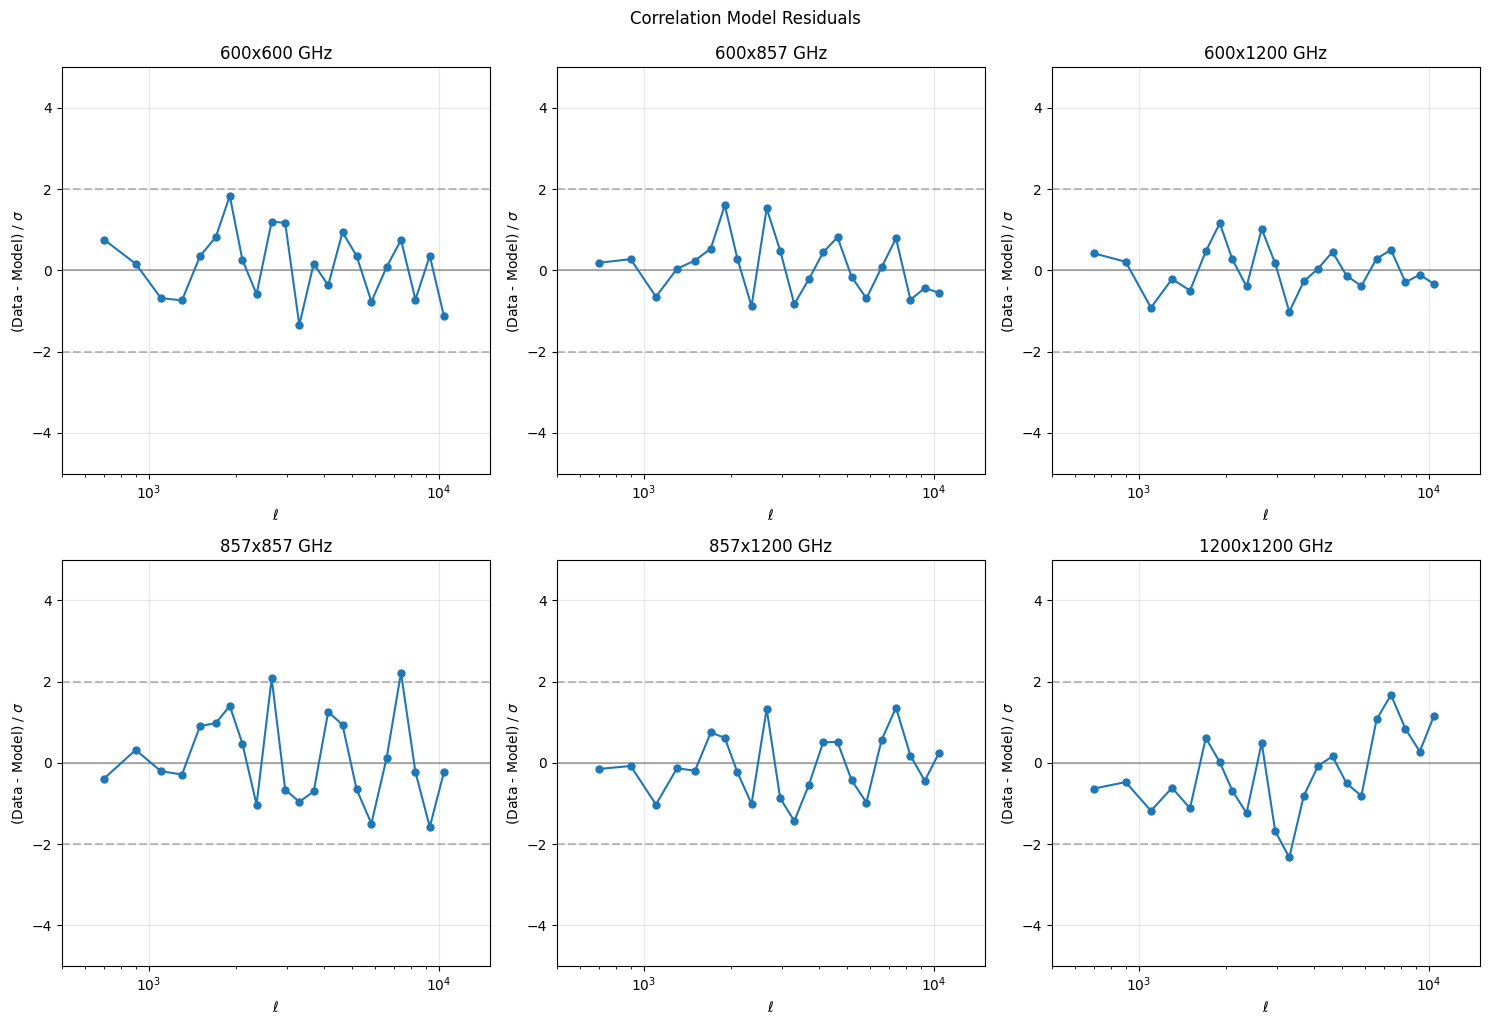

In [16]:
# Plot residuals
fig, axes = CIBPlotter.plot_residuals(data, model_corr, result_corr.params)
plt.suptitle('Correlation Model Residuals', y=1.02)
plt.show()

## 6. Chi-squared by Frequency Pair

In [17]:
# Get chi-squared breakdown by pair
chi2_simple = fitter_simple.chi2_by_pair(result_simple.params)
chi2_corr = fitter_corr.chi2_by_pair(result_corr.params)

print(f"{'Pair':<12} {'Simple χ²/N':<15} {'Corr χ²/N':<15} {'Improvement':<12}")
print("-" * 54)

for pair in CIBData.SPIRE_PAIRS:
    chi2_s, n = chi2_simple[pair]
    chi2_c, _ = chi2_corr[pair]
    delta = chi2_s - chi2_c
    print(f"{pair:<12} {chi2_s/n:>6.2f}          {chi2_c/n:>6.2f}          {delta:>+8.1f}")

Pair         Simple χ²/N     Corr χ²/N       Improvement 
------------------------------------------------------
600x600        2.84            0.68             +47.4
600x857        0.94            0.48             +10.1
600x1200      15.09            0.28            +325.8
857x857        1.56            1.10             +10.0
857x1200       1.50            0.55             +21.0
1200x1200      4.48            1.01             +76.5


## 7. Quick Fit Convenience Function

For rapid analysis, use the `quick_fit` function.

In [18]:
# Quick fit with sensible defaults
result, fitter = quick_fit(data_dir, model_type='correlation', n_terms=3)
print(result)

FitResult(χ²/dof = 90.4/122 = 0.74)
  C_shot: 0.0000
  C_1h: 3087.8197
  alpha_1h: -0.1361
  C_2h: 1019.8758
  alpha_2h: -1.7652
  A857: 2.4248
  A1200: 3.7754
  r_600_857: 0.9698
  r_600_1200: 0.8601
  r_857_1200: 0.9549


## 8. Physical Interpretation

The key findings from this analysis:

1. **Correlation coefficients** are directly measurable from the data:
   - $r(600\times857) \approx 0.97$
   - $r(600\times1200) \approx 0.86$
   - $r(857\times1200) \approx 0.96$

2. **The 600×1200 decorrelation** is the strongest because:
   - 600 GHz probes higher redshifts (z ~ 4) due to negative K-correction
   - 1200 GHz probes lower redshifts (z ~ 1.5)
   - T_dust evolves with redshift (Schreiber et al. 2018)

3. **The correlation model** significantly improves the fit:
   - Δχ² ~ 500 for 3 extra correlation parameters
   - Especially improves 600×1200 (χ² drops from ~300 to ~6)

In [19]:
# Extract fitted correlation coefficients
r_fitted = {
    '600x857': result_corr.params[model_corr.param_names.index('r_600_857')],
    '600x1200': result_corr.params[model_corr.param_names.index('r_600_1200')],
    '857x1200': result_corr.params[model_corr.param_names.index('r_857_1200')],
}

# Compare to directly measured values
r_measured = {pair: np.mean(r) for pair, r in diag.correlation_coefficients().items()}

print("Correlation coefficients:")
print(f"{'Pair':<12} {'Measured':<10} {'Fitted':<10}")
print("-" * 32)
for pair in ['600x857', '600x1200', '857x1200']:
    print(f"{pair:<12} {r_measured[pair]:<10.4f} {r_fitted[pair]:<10.4f}")

Correlation coefficients:
Pair         Measured   Fitted    
--------------------------------
600x857      0.9698     0.9698    
600x1200     0.8678     0.8601    
857x1200     0.9579     0.9549    
